<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [6.1 Static Operability](https://jckantor.github.io/cbe30338-2021/06.01-Static-Operability.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.0 Projects](https://jckantor.github.io/cbe30338-2021/07.00-Projects.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/06.02-Simulation-and-Open-Loop-Optimal-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/06.02-Simulation-and-Open-Loop-Optimal-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 6.2 Simulation and Open-Loop Optimal Control

This notebook demonstrates the use of CVXPY for the simulation and computation of open-loop optimal control. The notebook includes a lab exercise.

## 6.2.1 Heater Model

### 6.2.1.1 Model

We will use the two-state model for a single heater/sensor assembly for the calculations that follow.

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1 u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}

The model is recast into linear state space form as

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

where

$$x = \begin{bmatrix} T_{H,1} \\ T_{S,1} \end{bmatrix}
\qquad
u = \begin{bmatrix} u_1 \end{bmatrix}
\qquad
d = \begin{bmatrix} T_{amb} \end{bmatrix}
\qquad
y = \begin{bmatrix} T_{S,1} \end{bmatrix}$$

and

$$A = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} \end{bmatrix}
\qquad
B_u = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}
\qquad
B_d = \begin{bmatrix} \frac{U_a}{C_p^H} \\ 0 \end{bmatrix}
\qquad
C = \begin{bmatrix} 0 & 1 \end{bmatrix}$$


### 6.2.1.2 Parameter Values

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor

# state space model
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
Bu = np.array([[alpha*P1/CpH], [0]])     # single column
Bd = np.array([[Ua/CpH], [0]])           # single column
C = np.array([[0, 1]])                   # single rowe

## 6.2.2 The Control Problem

For the purposes of this notebook, the control problem is to find a control policy $u(t)$ for the interval $0 \leq t \leq t_f$ which causes the output $y(t)$ to track a desired setpoint or reference tracjectory $r(t)$.

### 6.2.2.1 Reference Tractory

The reference trajectory is a sequence of ramp/soak intervals.  Python function `r(t)` uses `numpy.interp` to compute values of the reference trajectory at any point in time.

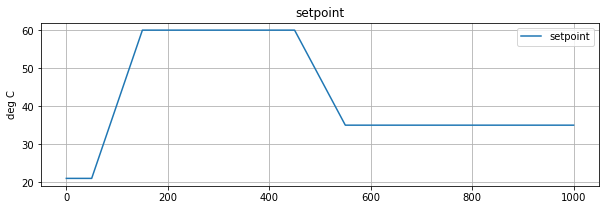

In [ ]:
# time grid
tf = 1000
dt = 2
n = round(tf/dt)
t_grid = np.linspace(0, 1000, n+1)

# ambient temperature
Tamb = 21

# setpoint/reference
def r(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])

# plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, r(t_grid), label="setpoint")
ax.set_title('setpoint')
ax.set_ylabel('deg C')
ax.legend()
ax.grid(True)

### 6.2.2.2 Guessing a Solution

So what should $u(t)$ be?  

The next cell defines process inputs $d(t)$ and $u(t)$. For this disturbance, the model parameters given above, do you think this control policy will cause $y(t)$ to be close to the reference trajectory?

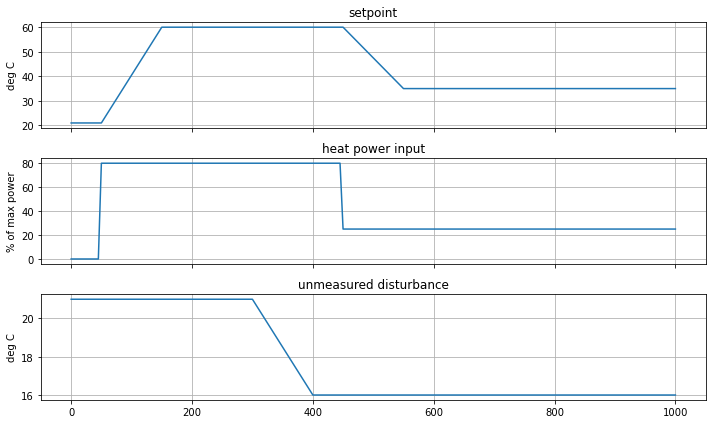

In [ ]:
def d(t):
    return np.interp(t, [0, 300, 400], [Tamb, Tamb, Tamb-5])

def u(t):
    return np.interp(t, [ 0, 50, 50, 450, 450], [ 0,  0, 80,  80,  25])

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
ax[0].plot(t, r(t))
ax[0].set_title('setpoint')
ax[0].set_ylabel('deg C')

ax[1].plot(t, u(t))
ax[1].set_title('heat power input')
ax[1].set_ylabel('% of max power')

ax[2].plot(t, d(t))
ax[2].set_title('unmeasured disturbance')
ax[2].set_ylabel('deg C')

for a in ax:
    a.grid(True)
plt.tight_layout()

## 6.2.3 Simulation

Let's see how well our initial guess at a control strategy will work for us subject to initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}

and prior specification of inputs $u(t)$ and $d(t)$.

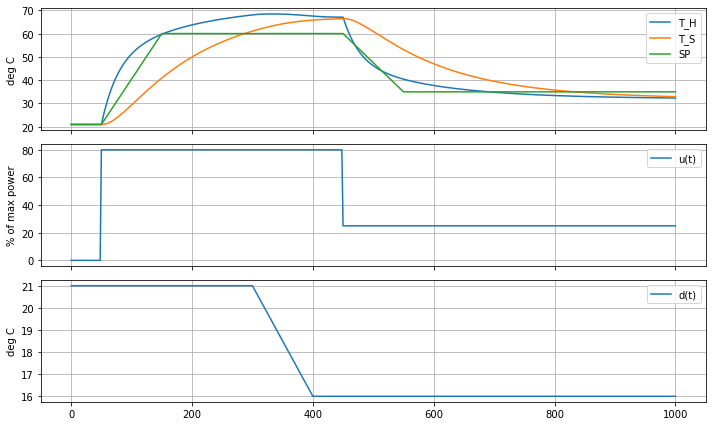

In [ ]:
# create a dictionary of unknowns indexed by time
x = {t: cp.Variable(2) for t in t_grid}
y = {t: cp.Variable(1) for t in t_grid}

# trivial objective
objective = cp.Minimize(0)

# model equation and initial condition
model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@[u(t-dt)] + Bd@[d(t-dt)]) for t in t_grid[1:]]
output = [y[t] == C@x[t] for t in t_grid]
IC = [x[0] == np.array([Tamb, Tamb])]

# create and solve optimization problem
problem = cp.Problem(objective,  model + IC + output)
problem.solve()

# display solution
fix, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
ax[0].plot(t_grid, [x[t][0].value  for t in t_grid], label="T_H")
ax[0].plot(t_grid, [x[t][1].value  for t in t_grid], label="T_S")
ax[0].plot(t_grid, [r(t) for t in t_grid], label="SP")
ax[0].set_ylabel("deg C")
ax[0].legend()
ax[1].plot(t_grid, [u(t) for t in t_grid], label="u(t)")
ax[1].set_ylabel("% of max power")
ax[2].plot(t_grid, [d(t) for t in t_grid], label="d(t)")
ax[2].set_ylabel("deg C")
for a in ax:
    a.grid(True)
    a.legend()
plt.tight_layout()

<hr>

**Study Question:** Evaluate how well this control policy performed. Keep in mind that the objective is for $T_S$ to track the reference input (i.e., the setpoint) as closely as possible. Did the controller achieve the desired steady-state? What about the prior ramp and soak periods? 

**Study Question:** Edit the cells above to change $u(t)$ in to produce a response closer to the target. Make at least 3 attempts. What changes did you make, and were you able to get a better result.

**Study Question:** What criteria could you use to determine if one control policy was better than another? Give at least three examples of possible criteria.

<hr>

## 6.2.4 Feedforward Optimal Control

An optimal control policy minimizes the differences

\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|T_H^{SP}(t) - T_H(t)\|^2\,dt \\
\end{align*}

subject to constraints

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}

initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}

and prior knowledge of $d(t)$.

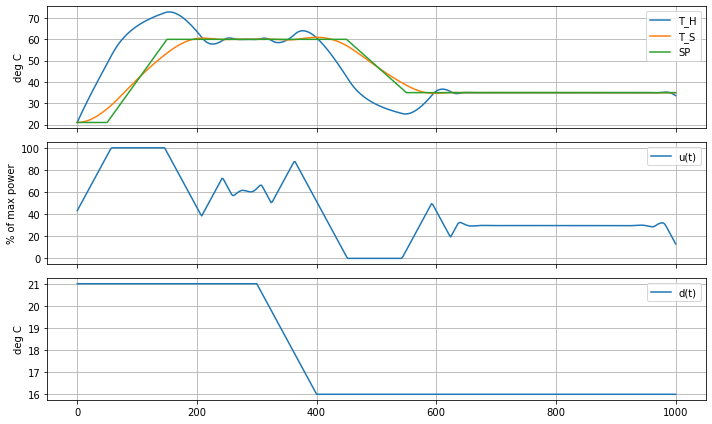

In [ ]:
# add $u$ as a decision variable
u = {t: cp.Variable(1, nonneg=True) for t in t_grid}
x = {t: cp.Variable(2) for t in t_grid}
y = {t: cp.Variable(1) for t in t_grid}

# least-squares optimization objective
objective = cp.Minimize(sum((y[t]-r(t))**2 for t in t_grid))

model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[d(t-dt)]) for t in t_grid[1:]]
output = [y[t] == C@x[t] for t in t_grid]
inputs = [u[t] <= 100 for t in t_grid]
IC = [x[0] == np.array([Tamb, Tamb])]
rate = [cp.abs(u[t] - u[t-dt]) <= dt*1 for t in t_grid[1:]]

problem = cp.Problem(objective,  model + IC + output + inputs + rate)
problem.solve()

# display solution
fix, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
ax[0].plot(t_grid, [x[t][0].value  for t in t_grid], label="T_H")
ax[0].plot(t_grid, [x[t][1].value  for t in t_grid], label="T_S")
ax[0].plot(t_grid, [r(t) for t in t_grid], label="SP")
ax[0].set_ylabel("deg C")
ax[0].legend()
ax[1].plot(t_grid, [u[t].value for t in t_grid], label="u(t)")
ax[1].set_ylabel("% of max power")
ax[2].plot(t_grid, [d(t) for t in t_grid], label="d(t)")
ax[2].set_ylabel("deg C")
for a in ax:
    a.grid(True)
    a.legend()
plt.tight_layout()

<hr>

**Study Question:** The optimal control computed above requires rapid changes in power level. In process systems where control action requires movement of a valve stem position, there are often limits on how fast the manipulated variable can change. Modify the model to include differential inequalities that limit the time rate of change of control.

\begin{align*}
\frac{du}{dt} & \leq \dot{u}_{max} \\
\frac{du}{dt} & \geq -\dot{u}_{max}
\end{align*}

where $\dot{u}_{max}$ is the maximum rate of change. Add these rate constraints to the problem above. Specify that the maximum power cannot change more than  1% per second.

How does that change the response?

**Study Question:** Change the objective so that the goal is to guide the heater (insteady of the sensor) temperature to the reference trajectory. How does the control policy change? Explain what you observe.

<hr>

## 6.2.5 Lab Assignment 8

The goal of this lab assignment is to extend the calculations shown above to the case of the four-state models with two manipulable inputs and independent setpoint functions for $T_{S,1}$ and $T_{S,2}$.

### 6.2.5.1 Exercise 1

In a new cell, create reference inputs for sensor temperatures $T_{S,1}$ and $T_{S,2}$. The new reference trajectories should 

* Set the final time to 800 seconds. 
* Use the same ramp/soak specifications as above for $T_{S,1}$
* For $T_{S,2}$, delay the ramp by 100 seconds, and set the soak temperature to 45C. The high temperature soak period should remain the same. The slopes of the ramps should remain the same. Plot your results.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

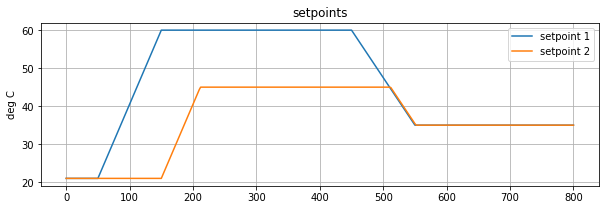

In [2]:
# time grid
tf = 800
dt = 2
n = round(tf/dt)
t_grid = np.linspace(0, tf, n+1)

# ambient temperature
Tamb = 21

# setpoint/reference
def r_SP1(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])
# Maintain the same slope
def r_SP2(t):
    return np.interp(t, [0, 150, 211.54, 511.54, 551.54], [Tamb, Tamb, 45, 45, 35])

def d(t):
    return np.interp(t, [0], [Tamb])

# plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, r_SP1(t_grid), label="setpoint 1")
ax.plot(t_grid, r_SP2(t_grid), label='setpoint 2')
ax.set_title('setpoints')
ax.set_ylabel('deg C')
ax.legend()
ax.grid(True)

### 6.2.5.2 Exercise 2

Set up and solve for the heater control policies minimizing the sum of least squares between the sensor temperatures and reference trajectories. Create functions U1(t) and U2(t) that interpolate the solutions for u1(t) and u2(t) for any value of t. Plot the results.

In [3]:
# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
CpH = 4.46            # heat capacity of the heater (J/deg C)
CpS = 0.819           # heat capacity of the sensor (J/deg C)
Ua = 0.050            # heat transfer coefficient from heater to environment
Ub = 0.021            # heat transfer coefficient from heater to sensor
Uc = 0.0335           # heat transfer coefficient between heaters
Tamb = 21             # ambient room temperature

# state space model
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# initial values for states and inputs
u_initial = np.array([0, 0])
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

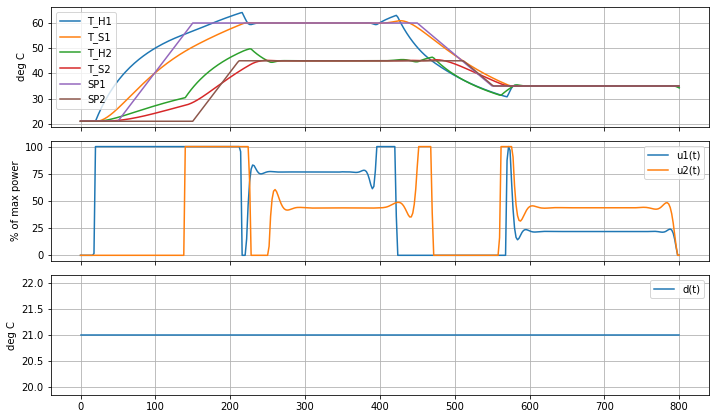

In [4]:
# add $u$ as a decision variable
u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
x = {t: cp.Variable(4) for t in t_grid}
y = {t: cp.Variable(2) for t in t_grid}

# least-squares optimization objective
objective = cp.Minimize(sum((y[t][0]-r_SP1(t))**2 + (y[t][1]-r_SP2(t))**2  for t in t_grid))

model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[d(t-dt)]) for t in t_grid[1:]]
output = [y[t] == C@x[t] for t in t_grid]
inputs = [u[t] <= 100 for t in t_grid]
IC = [x[0] == np.array([Tamb, Tamb, Tamb, Tamb])]

problem = cp.Problem(objective,  model + IC + output + inputs)
problem.solve()

# display solution
fix, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
ax[0].plot(t_grid, [x[t][0].value  for t in t_grid], label="T_H1")
ax[0].plot(t_grid, [x[t][1].value  for t in t_grid], label="T_S1")
ax[0].plot(t_grid, [x[t][2].value  for t in t_grid], label="T_H2")
ax[0].plot(t_grid, [x[t][3].value  for t in t_grid], label="T_S2")
ax[0].plot(t_grid, [r_SP1(t) for t in t_grid], label="SP1")
ax[0].plot(t_grid, [r_SP2(t) for t in t_grid], label="SP2")
ax[0].set_ylabel("deg C")
ax[0].legend()
ax[1].plot(t_grid, [u[t][0].value for t in t_grid], label="u1(t)")
ax[1].plot(t_grid, [u[t][1].value for t in t_grid], label="u2(t)")
ax[1].set_ylabel("% of max power")
ax[2].plot(t_grid, [d(t) for t in t_grid], label="d(t)")
ax[2].set_ylabel("deg C")
for a in ax:
    a.grid(True)
    a.legend()
plt.tight_layout()

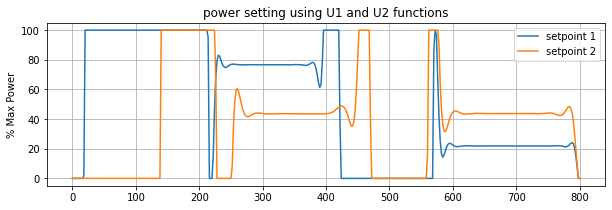

In [5]:
# Create U1 and U2 functions by interpolation:
u1_list = [u[t][0].value for t in t_grid]
u2_list = [u[t][1].value for t in t_grid]

def U1(t):
    return np.interp(t, t_grid, u1_list)
def U2(t):
    return np.interp(t, t_grid, u2_list)

# plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, U1(t_grid), label="setpoint 1")
ax.plot(t_grid, U2(t_grid), label='setpoint 2')
ax.set_title('power setting using U1 and U2 functions')
ax.set_ylabel('% Max Power')
ax.legend()
ax.grid(True)

### 6.2.5.3 Exercise 3

Apply the functions U1(t) and U2(t) to your hardware and compare the measured sensor temperatures to those predicted in Exercise 2. How did you do?

<!--NAVIGATION-->
< [6.1 Static Operability](https://jckantor.github.io/cbe30338-2021/06.01-Static-Operability.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.0 Projects](https://jckantor.github.io/cbe30338-2021/07.00-Projects.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/06.02-Simulation-and-Open-Loop-Optimal-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/06.02-Simulation-and-Open-Loop-Optimal-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>